# Final Project: Monocular depth (Topic 9)

## 1. Abstract

In Assignment 3, we implemented both the window-based and scan-line approaches to estimate the disparity map for a given stereo pair. However, these algorithms do not provide a generalized solution capable of producing a disparity map for any input image.

In this project, we developed a self-supervised single-image (monocular) depth estimation using a convolutional neural network. Initially, we evaluated the neural network's performance by training it on a set of single-image samples. Subsequently, we trained the neural network using 250 samples from diving scenario stereo pairs and tested its performance on images not included in the training set.

## 2. Team Members and Contributions

- Alex Wang (j2373wan@uwaterloo.ca): Find Dataset, Implement Training, Implement Helper Function, Write Up, Debug/Tunning

- Suyeong Choi (s88choi@uwaterloo.ca): Implement Dataloader, Implement Loss function, Debug/Tunning

- Colby Wang (c684wang@uwaterloo.ca): Implement the Neural Network, Debug/Tunning

## 3. Code Libraries

### 3.1 External Libraries
- pytorch_ssim: Used to calcuate the structural similarity between images that is important for our loss function computation, necessary files are in the 'extlibs' subdirectory

- pytorch: Used to build neural network, install instruction: https://pytorch.org/get-started/locally/

- tqdm: Used to display traning progress, install instruction: https://pypi.org/project/tqdm/

- numpy and matplotlib is assumed to be installed with the default anaconda package

### 3.2 Our Own Libraries
- UNet: Defines the Neural Network class. It contains the initialization of the Neural Network and the forward pass definition

- loss_function: Defines the Loss Function class. It contains the function to reconstruct images from disparity map and original image called 'apply disparity', function to calculate structrual similarity called SSIM, function to computer smoothness, and the forward pass definition of the loss function

### 3.3 Import Code, Global Variable Definition, Helper Function Definition

In [1]:
%matplotlib notebook
import numpy as np
import torch
import torch.optim as optim
from tqdm import tqdm
import matplotlib.image as image
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader

from Unet import UNet                             # The Neural Network (by Colby Wang)
from loss_function import MonocularDepthLoss      # Loss Function      (by Suyeong Choi)
from dataloader import CustomDataset              # Custom Dataloader  (by Suyeong Choi)

# Path Variables
DATASET_PATH = 'dataset'
LEFT = 'image_L'
RIGHT = 'image_R'
DISPARITY = 'disparity'

# Define device for training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


# Helper Functions for Cropping image and Tensor permutation (by Alex Wang)
def image_transform_single(img, height, width):
    
    # Make sure all the image sample has same size defined by (height, width) by cutting the image or filling 0s
    result = np.zeros((height, width, 3), dtype=np.float32)
    img_height = img.shape[0]
    img_width = img.shape[1]
    min_height = min(img_height, height)
    min_width = min(img_width, width)
    result[:min_height, :min_width,:] = img[:min_height, :min_width,:]
    
    # The returned value should have 3 matrices for each channel
    return np.array([result[:,:,0], result[:,:,1], result[:,:,2]])

def disparity_transform(disparity, height, width):
    result = np.zeros((height, width), dtype=np.float32)
    d_height = disparity.shape[0]
    d_width = disparity.shape[1]
    min_height = min(d_height, height)
    min_width = min(d_width, width)
    result[:min_height, :min_width] = disparity[:min_height, :min_width]
    return result

def image_transform(sample):
    result_sample = {LEFT: image_transform_single(sample[LEFT], HEIGHT, WIDTH)}
    if sample[RIGHT] is not None:
        result_sample[RIGHT] = image_transform_single(sample[RIGHT], HEIGHT, WIDTH)
        result_sample[DISPARITY] = disparity_transform(sample[DISPARITY], HEIGHT, WIDTH)
    return result_sample

## 4. Methodology

### 4.1 General Idea for Training

Step 1: Utilize a stereo pair as input to the neural network.

Step 2: Generate the two estimated disparity maps for the left and right images.

Step 3: Reconstruct the right image from the left image using the left disparity map.

Step 4: Reconstruct the left image from the right image using the right disparity map.

Step 5: Compute the loss by comparing the original images with the reconstructed images.

Step 6: Implement backpropagation using the calculated loss.

Repeat Steps 2-6 for multiple epochs to train the neural network model.

### 4.2 Neural Network Implementation
The Neural Network is defined in the file 'Unet.py'. It consist of 4 encoder blocks, each of them is a 2d convolution layer with ReLU as activation function, and the 4 decoder blocks corresponding to each encoder block.

The input channel number at each encoder blocks are 3, 64, 128, 256 respectively with kernel size = (3, 3) and padding = 1

### 4.3 Loss Function Implementation
After getting the reconstructed left and right images, loss function is calcuated based on the following:

- A = derivative of mean square error between the reconstructed image and the actual image

- B = structual similarity between the reconstructed image and the actual image

- C = LR consistency

- D = disparities smoothness

The function to calculate each part is defined in 'loss_function.py'

The loss function takes additional 3 hyperparameter: $\alpha$, $\beta$, $\gamma$

The loss function is then calculated by:
$ Loss = \alpha B + (1-\alpha) A + \beta C + \gamma D $

After tunning, we assign $\alpha = 0.2 $, $\beta = 1.0$, $\gamma = 1.0$ for all the training below

## 5. Demo for Single Image Part 1 (Good Case: Tsukuba）

### 5.1 Read Input
The sample is getting from 'Tsukuba', we used it in Assignment 3 as well

In [2]:
im_left = image.imread("images/stereo_pairs/tsukuba/scene1.row3.col3.ppm")
im_gt = image.imread("images/stereo_pairs/tsukuba/truedisp.row3.col3.pgm")
im_right = image.imread("images/stereo_pairs/tsukuba/scene1.row3.col4.ppm")

### 5.2 Training (Overfit to one image)

Training Epochs:   0%|                                                                        | 0/1000 [00:00<?, ?it/s]C:\Users\alexw\anaconda3\Lib\site-packages\torch\nn\functional.py:4316: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
Training Epochs: 100%|█████████████████████████████████████████████████████████████| 1000/1000 [00:37<00:00, 26.47it/s]

Training complete. The model should have overfit to the single image.


<IPython.core.display.Javascript object>


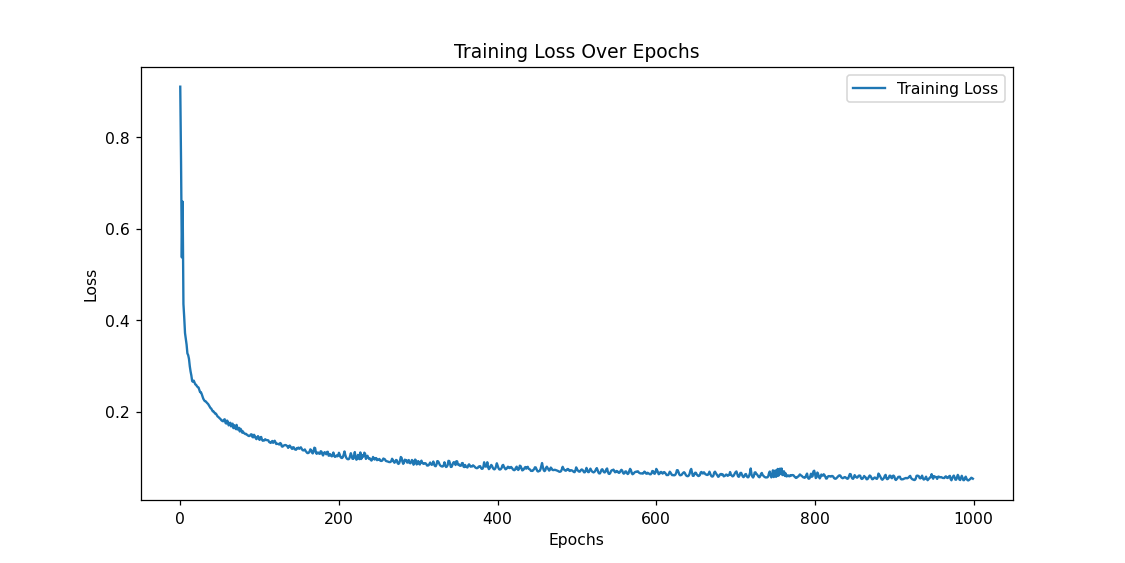

In [3]:
# Initialize the U-Net model and loss function
model = UNet()
loss_function = MonocularDepthLoss()

# Crop the image, change to float representation, and convert to tensor (single image, HWC format)
image_l = image_transform_single(im_left, im_left.shape[0], im_left.shape[1])
image_r = image_transform_single(im_right, im_right.shape[0], im_right.shape[1])
image_l = (image_l / 255).astype(np.float32)
image_r = (image_r / 255).astype(np.float32)
image_l = torch.from_numpy(np.expand_dims(image_l, axis=0)).to(device)
image_r = torch.from_numpy(np.expand_dims(image_r, axis=0)).to(device)

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Number of epochs to train (set high to see if it can overfit)
epochs = 1000

# List to record losses
loss_history = []

left_image = None
right_image = None

# Training loop
model.to(device)
model.train()  # Set model to training mode
for epoch in tqdm(range(epochs), desc="Training Epochs"):
    optimizer.zero_grad()

    # Forward pass
    right_disparity, left_disparity = model(image_l)

    # Calculate loss
    loss, left_image_recons, right_image_recons = loss_function(left_disparity, image_l, image_r, right_disparity)
    loss_history.append(loss.item())

    # Backward pass and optimize
    loss.backward()
    optimizer.step()

print("Training complete. The model should have overfit to the single image.")

plt.figure(figsize=(10, 5))
plt.plot(loss_history, label='Training Loss')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


### 5.3 Demostration of the reconstructed left and right image

<IPython.core.display.Javascript object>


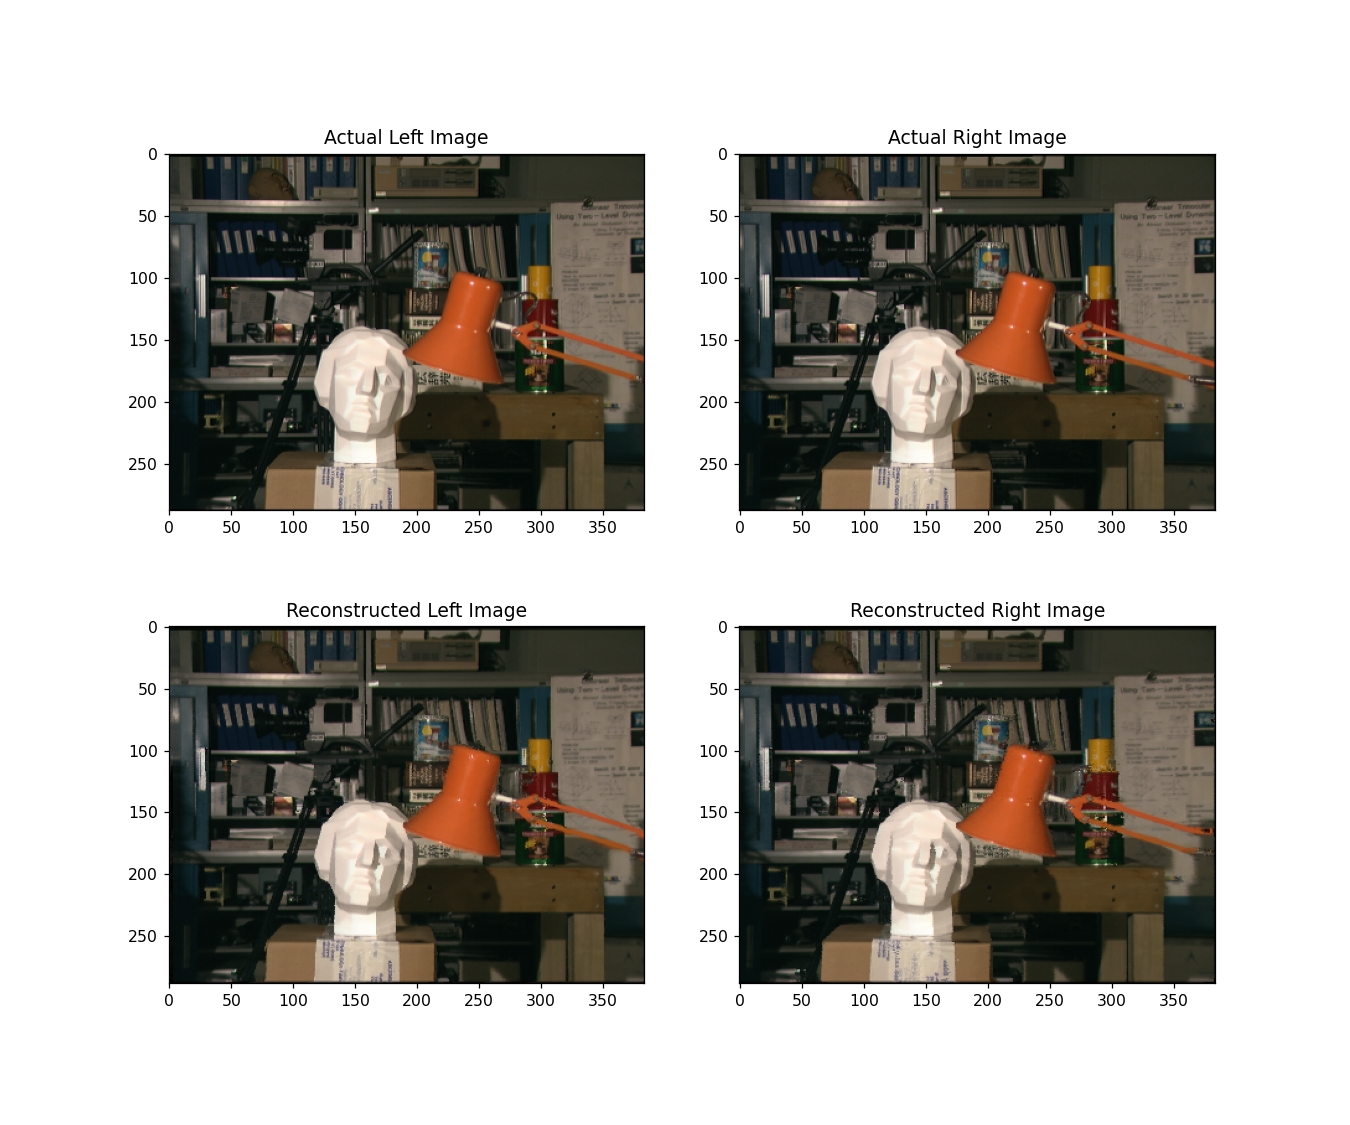

In [4]:
# Fetch the reconstructed left and right image, then convert to numpy
left_image_recons = left_image_recons.squeeze(0).cpu().detach().numpy().transpose(1,2,0)
right_image_recons = right_image_recons.squeeze(0).cpu().detach().numpy().transpose(1,2,0)

# Plot
fig = plt.figure(figsize = (12, 10))
plt.subplot(221)
plt.title("Actual Left Image")
plt.imshow(im_left)
plt.subplot(222)
plt.title("Actual Right Image")
plt.imshow(im_right)
plt.subplot(223)
plt.title("Reconstructed Left Image")
plt.imshow(left_image_recons)
plt.subplot(224)
plt.title("Reconstructed Right Image")
plt.imshow(right_image_recons)
plt.show()

### 5.4 Result demo on the single training data (overfitting)

<IPython.core.display.Javascript object>


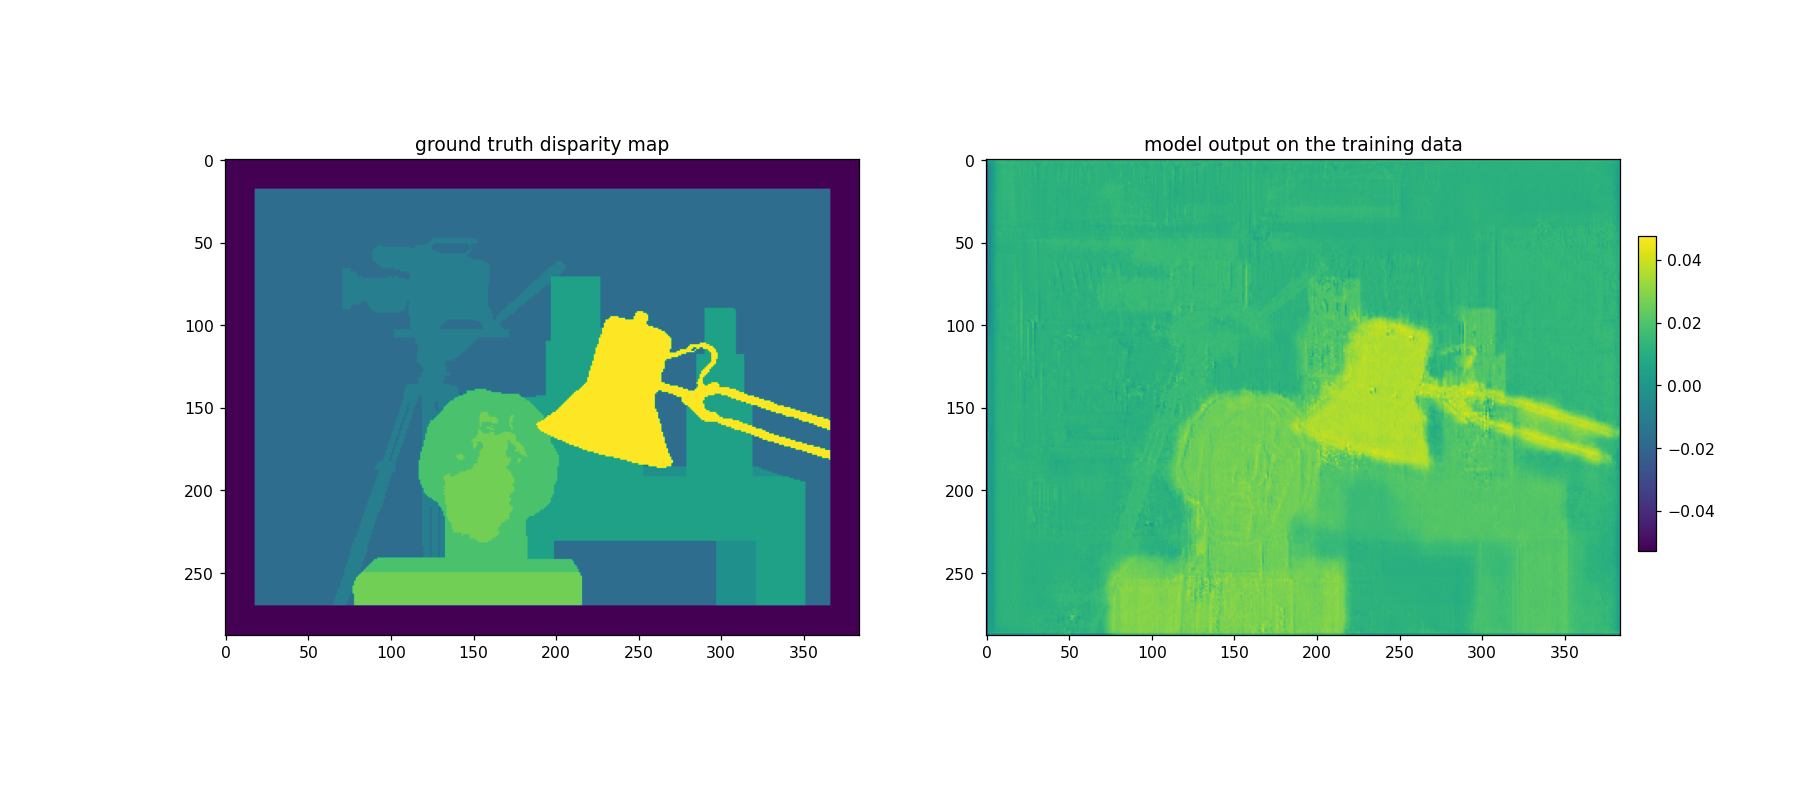

In [5]:
# Fetch output and convert to numpy
out_r_dmap, out_l_dmap = model(image_l)
output = out_l_dmap.detach().cpu()
output = torch.Tensor.numpy(output)
output = output.reshape(output.shape[2], output.shape[3])

fig = plt.figure(figsize = (16, 7))
plt.subplot(121)
plt.title("ground truth disparity map")
plt.imshow(im_gt)
plt.subplot(122)
plt.title("model output on the training data")
plt.imshow(output)
plt.colorbar(cax=plt.axes([0.91, 0.3, 0.01, 0.4]))
plt.show()

### 5.5 Analysis

By overfitting the model to the Tsukuba example, the reconstructed images are nearly identical to the original images, as shown in Section 5.3.

The output disparity map also accurately estimates the ground truth disparity map.

Therefore, we can conclude that this model (overfitting to Tsukuba) can almost perfectly estimate the disparity map for the Tsukuba example.

## 6. Demo for Single Image Part 2（Bad Case: single image from training set）

### 6.1 Read Input

The sample is one single stereo pair from the training set we used for batch training in section 7, the detail of the training set will be described there.

In [6]:
im_left = image.imread("dataset/image_L/2018-07-09-16-11-56_2018-07-09-16-20-56-472.jpg")
im_gt = image.imread("dataset/disparity/2018-07-09-16-11-56_2018-07-09-16-20-56-472.png")
im_right = image.imread("dataset/image_R/2018-07-09-16-11-56_2018-07-09-16-20-56-472.jpg")

### 6.2 Training (Overfit to one image)

Training Epochs: 100%|█████████████████████████████████████████████████████████████| 1000/1000 [01:29<00:00, 11.23it/s]

Training complete. The model should have overfit to the single image.


<IPython.core.display.Javascript object>


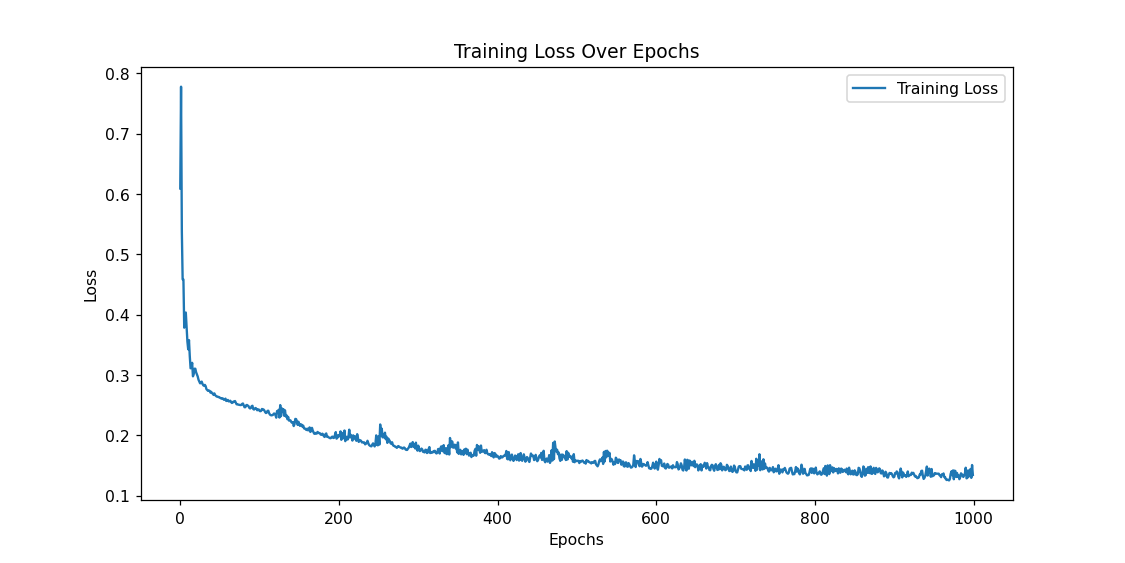

In [7]:
# Initialize the U-Net model and loss function
model = UNet()
loss_function = MonocularDepthLoss()

# Crop the image, change to float representation, and convert to tensor (single image, HWC format)
image_l = image_transform_single(im_left, 400, 880)
image_r = image_transform_single(im_right, 400, 880)
image_l = (image_l / 255).astype(np.float32)
image_r = (image_r / 255).astype(np.float32)
image_l = torch.from_numpy(np.expand_dims(image_l, axis=0)).to(device)
image_r = torch.from_numpy(np.expand_dims(image_r, axis=0)).to(device)

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Number of epochs to train (set high to see if it can overfit)
epochs = 1000

# List to record losses
loss_history = []

left_image = None
right_image = None

# Training loop
model.to(device)
model.train()  # Set model to training mode
for epoch in tqdm(range(epochs), desc="Training Epochs"):
    optimizer.zero_grad()

    # Forward pass
    right_disparity, left_disparity = model(image_l)

    # Calculate loss
    loss, left_image_recons, right_image_recons = loss_function(left_disparity, image_l, image_r, right_disparity)
    loss_history.append(loss.item())

    # Backward pass and optimize
    loss.backward()
    optimizer.step()

print("Training complete. The model should have overfit to the single image.")

plt.figure(figsize=(10, 5))
plt.plot(loss_history, label='Training Loss')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### 6.3 Demostration of the reconstructed left and right image

<IPython.core.display.Javascript object>


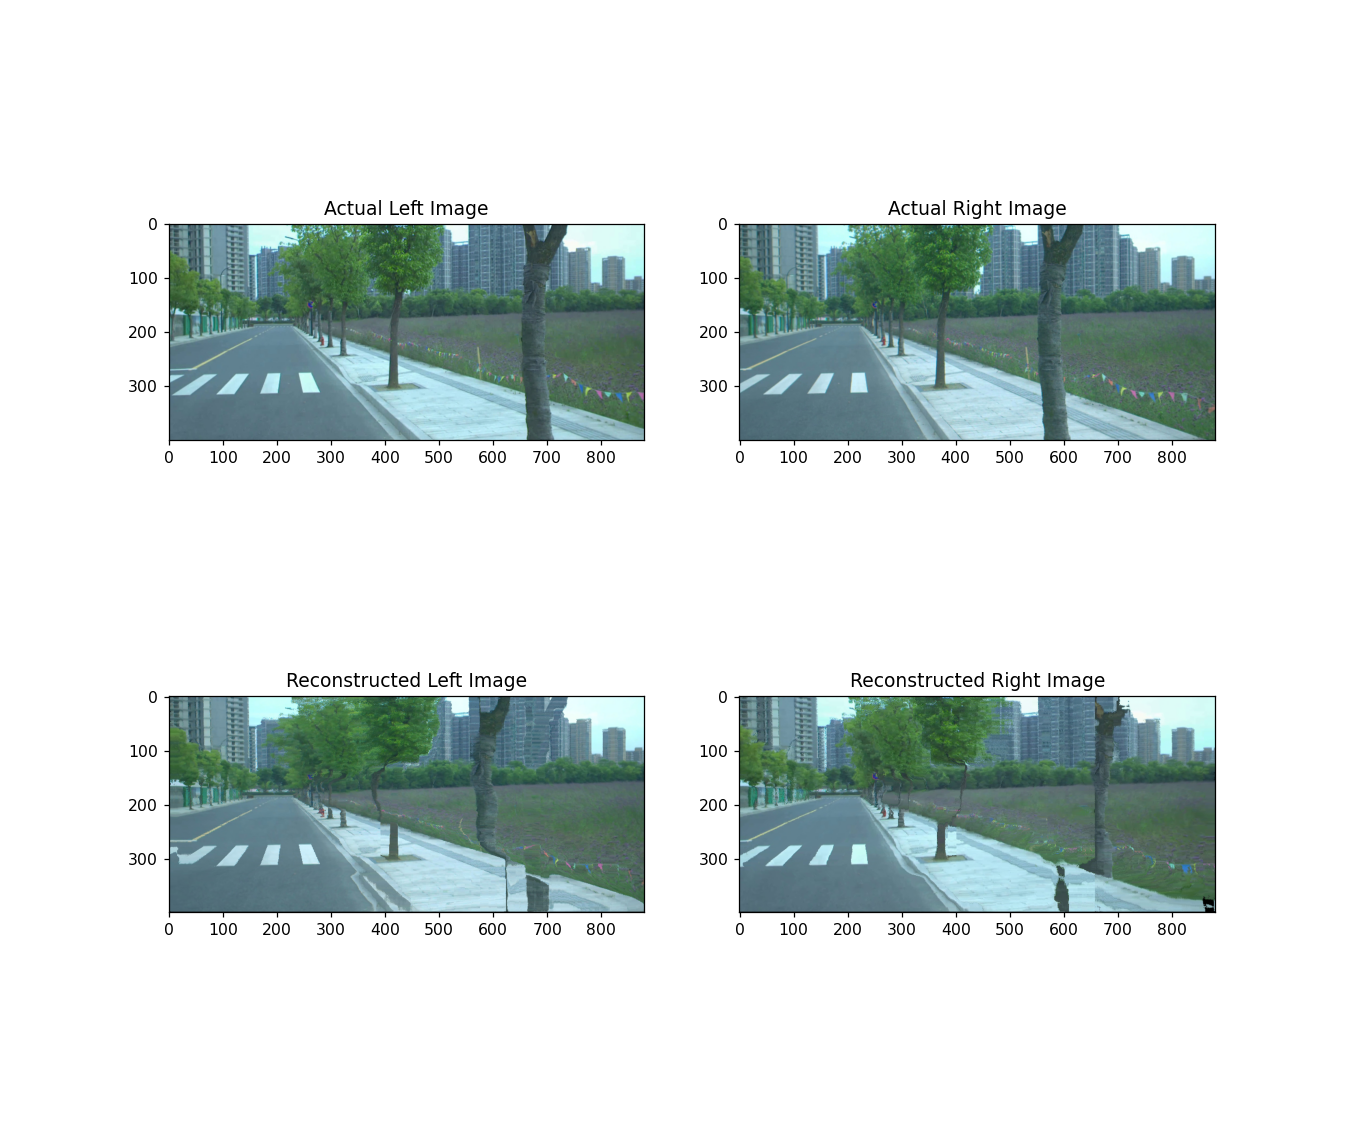

In [8]:
# Fetch the reconstructed left and right image, then convert to numpy
left_image_recons = left_image_recons.squeeze(0).cpu().detach().numpy().transpose(1,2,0)
right_image_recons = right_image_recons.squeeze(0).cpu().detach().numpy().transpose(1,2,0)

# Plot
fig = plt.figure(figsize = (12, 10))
plt.subplot(221)
plt.title("Actual Left Image")
plt.imshow(im_left)
plt.subplot(222)
plt.title("Actual Right Image")
plt.imshow(im_right)
plt.subplot(223)
plt.title("Reconstructed Left Image")
plt.imshow(left_image_recons)
plt.subplot(224)
plt.title("Reconstructed Right Image")
plt.imshow(right_image_recons)
plt.show()

### 6.4 Result demo on the single training data (overfitting)

<IPython.core.display.Javascript object>


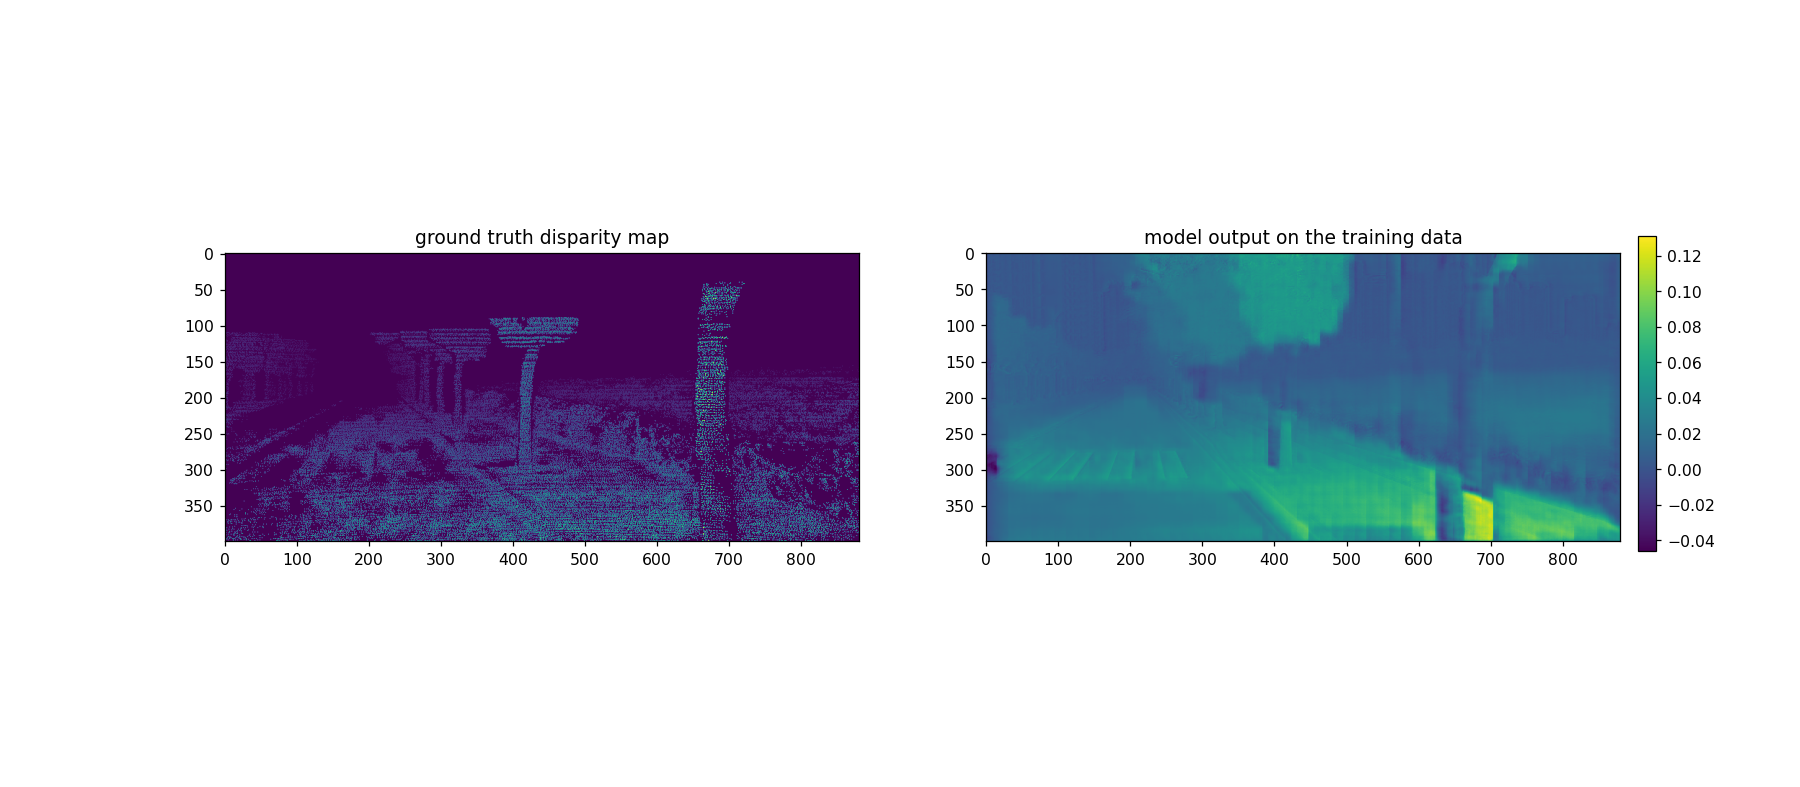

In [9]:
# Fetch output and convert to numpy
out_r_dmap, out_l_dmap = model(image_l)
output = out_l_dmap.detach().cpu()
output = torch.Tensor.numpy(output)
output = output.reshape(output.shape[2], output.shape[3])

fig = plt.figure(figsize = (16, 7))
plt.subplot(121)
plt.title("ground truth disparity map")
plt.imshow(im_gt)
plt.subplot(122)
plt.title("model output on the training data")
plt.imshow(output)
plt.colorbar(cax=plt.axes([0.91, 0.3, 0.01, 0.4]))
plt.show()

### 6.5 Analysis

In this case, we observe that the model cannot perfectly reconstruct the left and right images after training for 1000 epochs, as shown in Section 6.3.

The estimated disparity map seems to react to the zebra line, which does not contribute to disparity, and it failed to recognize the closest tree. However, the output disparity map successfully identifies the other trees and predicts that the closer tree has a larger disparity. It also successfully predicts the disparity for the road, as we observe a gradual decrease in disparity as the road moves further away from the viewpoint.

The potential reason for the failure of image reconstruction could be the fact that the closest tree is too close, resulting in a large pixel distance of the tree between the two images. This makes it difficult for the model to adjust the entire tree when reconstructing. This problem could potentially be addressed by using more epochs during training.

Therefore, although the model failed to perfectly reconstruct the left and right images, the output disparity map still makes sense for other elements in the image.

## 7. Batch Training

### 7.1 Training Summary

a. Dataset Description

The dataset was obtained from the Driving Stereo dataset (https://drivingstereo-dataset.github.io/), a large-scale dataset for stereo matching in autonomous driving scenarios. The dataset we are utilizing consists of 250 stereo pairs of traffic images captured in China.

b. Training Process

The training was performed in another Jupyter Notebook (Training_Demo.ipynb), where it executed the training and displayed the loss plot. The model was saved as 'model.pth'.

Training was carried out with a learning rate of 0.001, a batch size of 5, and 2000 epochs.

The training process took approximately 12 hours to complete.


In [10]:
# Load Model
model_path = 'model.pth'
model = UNet()
model.load_state_dict(torch.load(model_path))
model.eval()
model.to(device);

### 7.2 Result for one of the training data

<IPython.core.display.Javascript object>


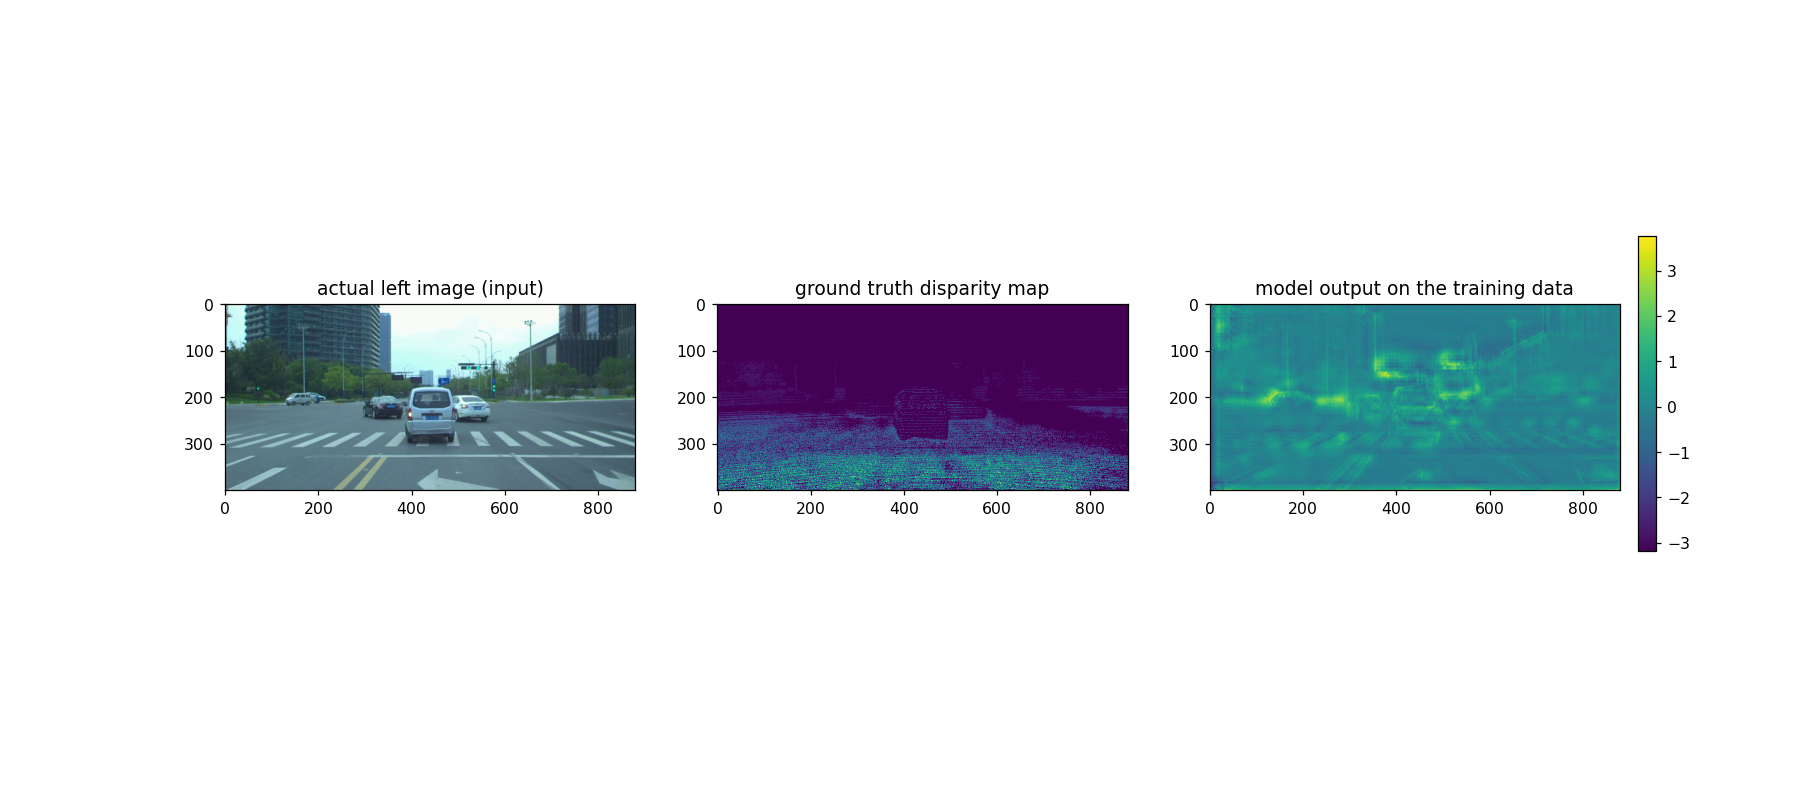

In [11]:
im_left = image.imread("dataset/image_L/2018-07-09-16-11-56_2018-07-09-16-12-58-336.jpg")
im_gt = image.imread("dataset/disparity/2018-07-09-16-11-56_2018-07-09-16-12-58-336.png")
im_right = image.imread("dataset/image_R/2018-07-09-16-11-56_2018-07-09-16-12-58-336.jpg")

image_l = image_transform_single(im_left, 400, 880)
image_r = image_transform_single(im_right, 400, 880)
image_l = torch.from_numpy(np.expand_dims(image_l, axis=0)).to(device)
image_r = torch.from_numpy(np.expand_dims(image_r, axis=0)).to(device)

out_r_dmap, out_l_dmap = model(image_l)
output = out_l_dmap.detach().cpu()
output = torch.Tensor.numpy(output)
output = output.reshape(output.shape[2], output.shape[3])

fig = plt.figure(figsize = (16, 7))
plt.subplot(131)
plt.title("actual left image (input)")
plt.imshow(im_left)
plt.subplot(132) 
plt.title("ground truth disparity map")
plt.imshow(im_gt)
plt.subplot(133)
plt.title("model output on the training data")
plt.imshow(output)
plt.colorbar(cax=plt.axes([0.91, 0.3, 0.01, 0.4]))
plt.show()

### 7.3 Result for Tsukuba (not in training set)

<IPython.core.display.Javascript object>


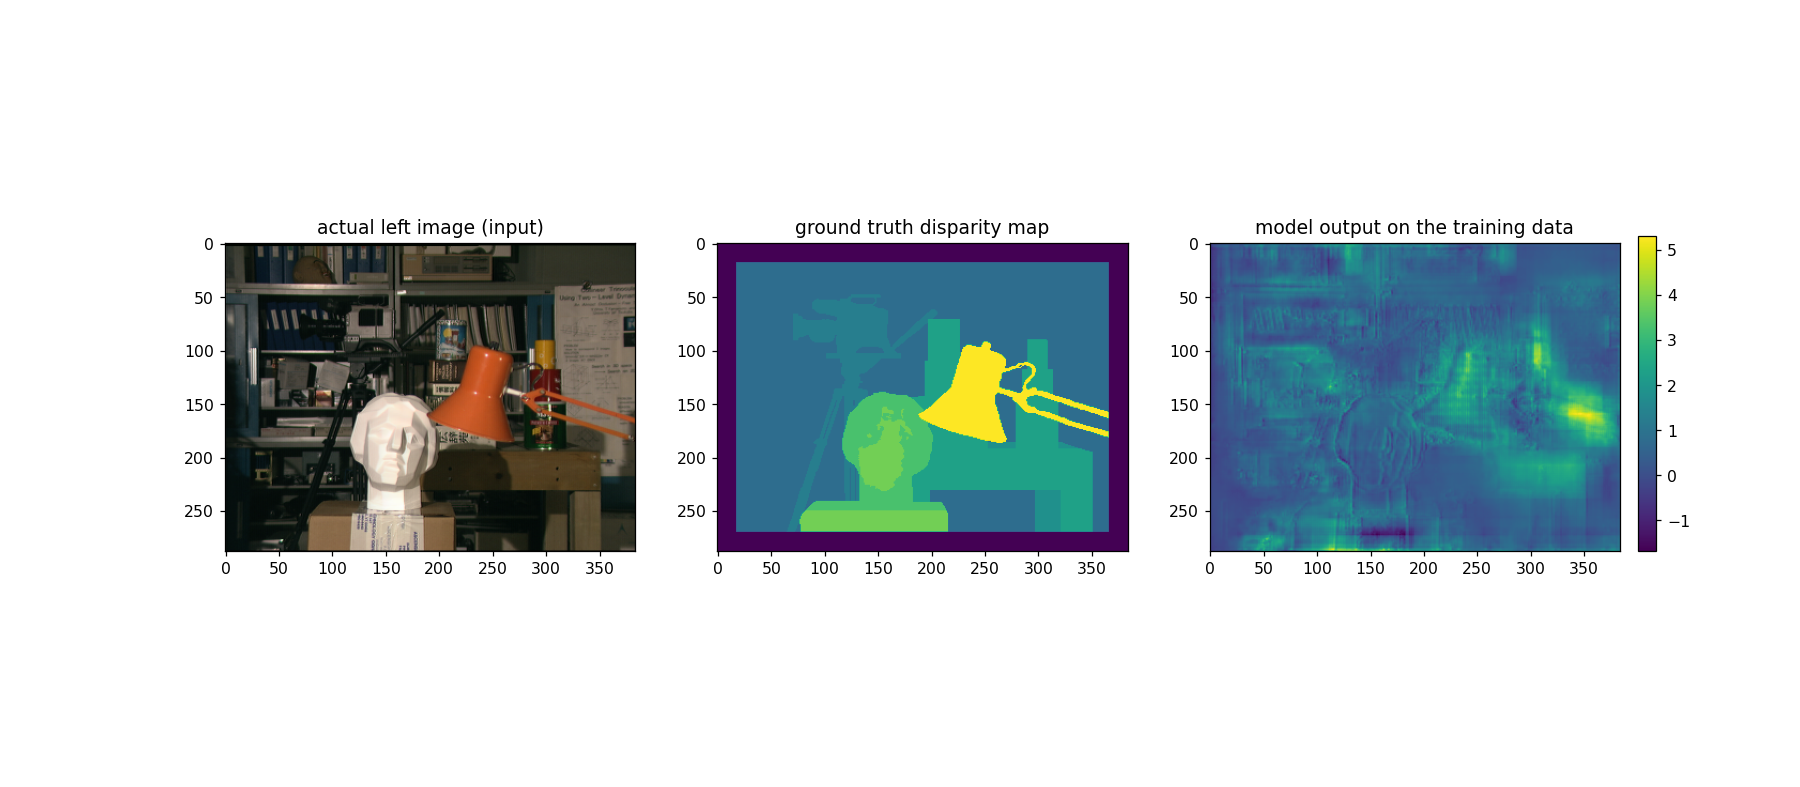

In [12]:
im_left = image.imread("images/stereo_pairs/tsukuba/scene1.row3.col3.ppm")
im_gt = image.imread("images/stereo_pairs/tsukuba/truedisp.row3.col3.pgm")
im_right = image.imread("images/stereo_pairs/tsukuba/scene1.row3.col4.ppm")

image_l = image_transform_single(im_left, im_left.shape[0], im_left.shape[1])
image_r = image_transform_single(im_right, im_right.shape[0], im_right.shape[1])
image_l = torch.from_numpy(np.expand_dims(image_l, axis=0)).to(device)
image_r = torch.from_numpy(np.expand_dims(image_r, axis=0)).to(device)

out_r_dmap, out_l_dmap = model(image_l)
output = out_l_dmap.detach().cpu()
output = torch.Tensor.numpy(output)
output = output.reshape(output.shape[2], output.shape[3])

fig = plt.figure(figsize = (16, 7))
plt.subplot(131)
plt.title("actual left image (input)")
plt.imshow(im_left)
plt.subplot(132) 
plt.title("ground truth disparity map")
plt.imshow(im_gt)
plt.subplot(133)
plt.title("model output on the training data")
plt.imshow(output)
plt.colorbar(cax=plt.axes([0.91, 0.3, 0.01, 0.4]))
plt.show()

### 7.4 Some additional results from other image not in the training set

3 images are getting from Pixabay (https://pixabay.com/)

<IPython.core.display.Javascript object>


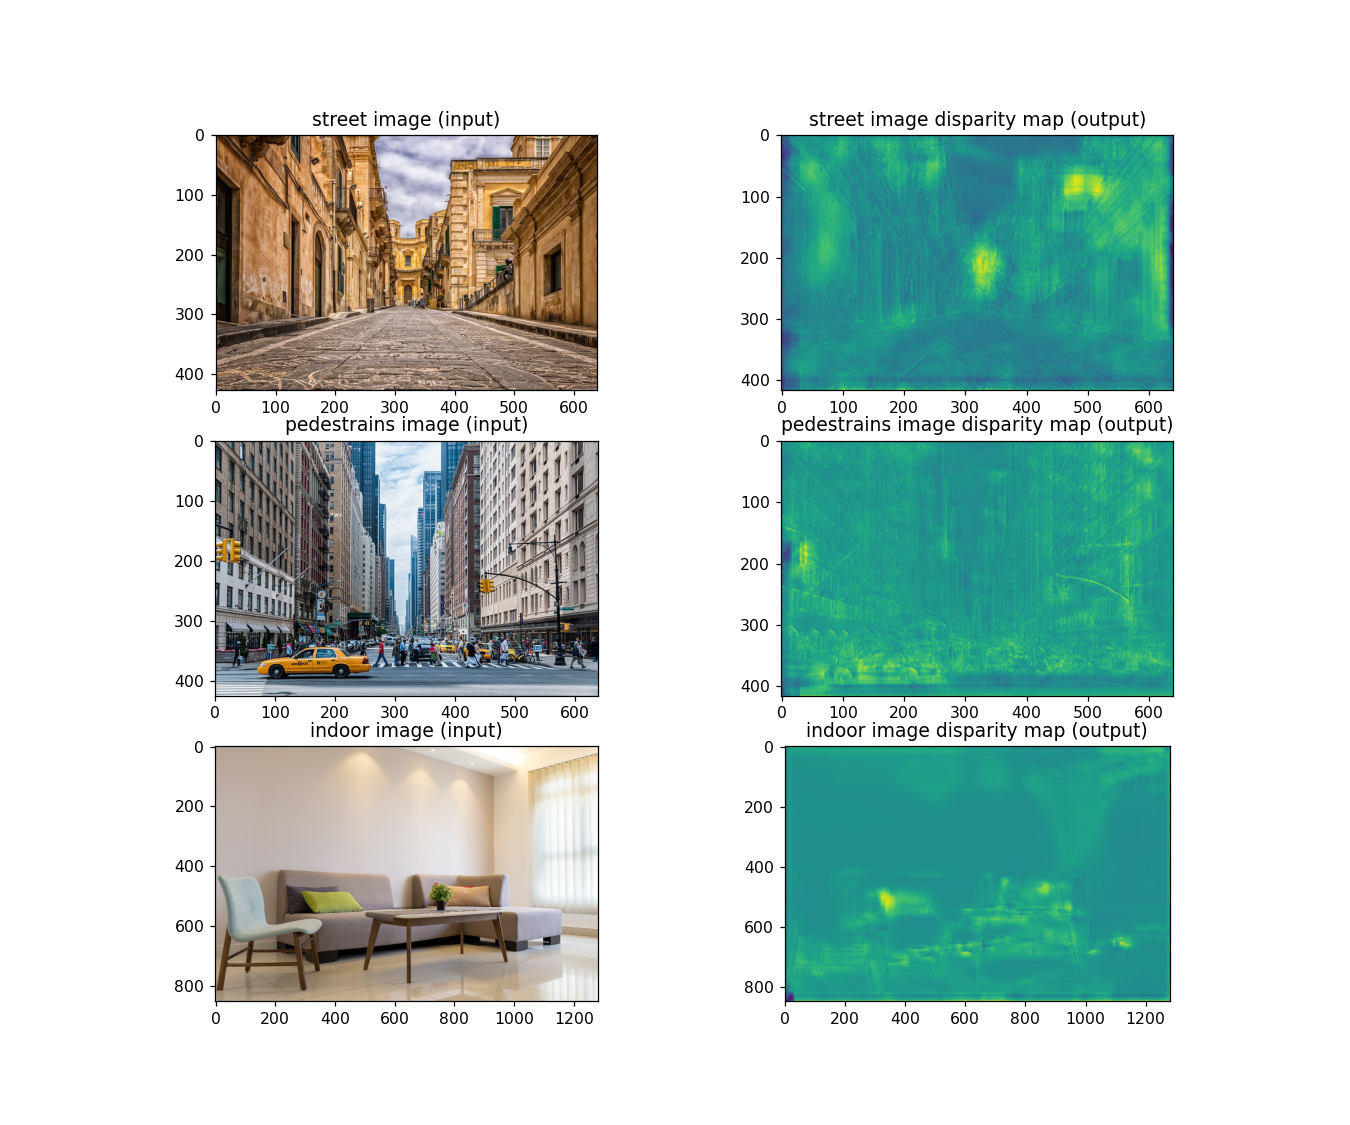

In [13]:
im_street = image.imread("images/street.jpg")
image_street = image_transform_single(im_street, 416, 640)
image_street = torch.from_numpy(np.expand_dims(image_street, axis=0)).to(device)
out_r_dmap_s, out_l_dmap_s = model(image_street)
output_s = out_l_dmap_s.detach().cpu()
output_s = torch.Tensor.numpy(output_s)
output_s = output_s.reshape(output_s.shape[2], output_s.shape[3])

im_ped = image.imread("images/pedestrians.jpg")
image_ped = image_transform_single(im_ped, 416, 640)
image_ped = torch.from_numpy(np.expand_dims(image_ped, axis=0)).to(device)
out_r_dmap_p, out_l_dmap_p = model(image_ped)
output_p = out_l_dmap_p.detach().cpu()
output_p = torch.Tensor.numpy(output_p)
output_p = output_p.reshape(output_p.shape[2], output_p.shape[3])

im_indoor = image.imread("images/indoor.jpg")
image_indoor = image_transform_single(im_indoor, 848, 1280)
image_indoor = torch.from_numpy(np.expand_dims(image_indoor, axis=0)).to(device)
out_r_dmap_i, out_l_dmap_i = model(image_indoor)
output_i = out_l_dmap_i.detach().cpu()
output_i = torch.Tensor.numpy(output_i)
output_i = output_i.reshape(output_i.shape[2], output_i.shape[3])

fig = plt.figure(figsize = (12, 10))
plt.subplot(321)
plt.title("street image (input)")
plt.imshow(im_street)
plt.subplot(322) 
plt.title("street image disparity map (output)")
plt.imshow(output_s)
plt.subplot(323)
plt.title("pedestrains image (input)")
plt.imshow(im_ped)
plt.subplot(324)
plt.title("pedestrains image disparity map (output)")
plt.imshow(output_p)
plt.subplot(325)
plt.title("indoor image (input)")
plt.imshow(im_indoor)
plt.subplot(326)
plt.title("indoor image disparity map (output)")
plt.imshow(output_i)
plt.show()

### 7.5 Analysis

a. For the results in Section 7.2, we observe that the model does not perfectly predict the disparity map for a single sample from the training set. This is because the model is now trained on all data in the training set, which means it is more general. Moreover, due to the reasons discussed in Section 6.5, errors persist even when we overfit to a single sample. However, the results shown in 7.2 still make sense because the cars are recognized with a larger disparity compared to the background, indicating their closer proximity.

b. For the results in Section 7.3, although the model still successfully predicted the disparity map for the lamp, it generally does not perform well on the Tsukuba example. This is because the training set we are using consists of all traffic images, making the model adept at identifying traffic elements like cars, traffic lights, and trees instead of the art studio elements present in the Tsukuba example.

c. For the results in Section 7.4:

The street example completely fools our model into believing that the architecture in the background is closer. This is also because our model is trained on traffic images and is less sensitive to building structures like this.

As proof, the prediction for the pedestrian image works nicely. It successfully recognized the taxi, pedestrians, and the traffic light as closer objects, and the background sky is further away. We can also observe a gradual decrease in disparity for the buildings from close to far as well.

As for the indoor example, although the elements in the image are completely different from our training model, the prediction still recognized some of the furniture as closer objects.

### 7.6 Potential Failure Reasons

- Hardware Limitations: Our model is trained on 250 samples with a batch size of 5. To complete 2000 epochs, it requires approximately 12 hours. With improved hardware, it would be possible to train on a larger dataset with more than 2000 epochs to achieve a more optimal result.

- Dataset: Our model is trained solely on autonomous driving scenarios, which limits its ability to react to elements outside of these scenarios. Including image pairs from other scenarios such as architecture, furniture, and sculptures for training could enhance the model's performance.

## 8. Conclusions

Our neural network model successfully generated the disparity map for the Tsukuba example when overfitting to it. Similarly, when overfitting to extreme driving scenario image pairs, the model produced a reasonable disparity map for them as well.

After training for 2000 epochs on 250 driving scenario image pairs, our model can accurately predict the disparity map for traffic-related image inputs and make some reasonable predictions for other scenarios, except for some special cases.